In [1]:
import os
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras

np.random.seed(9630)
tf.random.set_seed(9630)

print(tf.__version__)

2.8.0


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

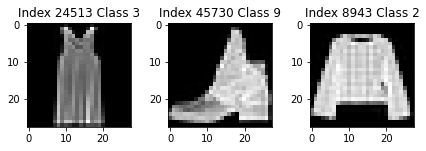

In [19]:
# Load MNIST or FMNIST

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data() 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

In [20]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [21]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [22]:
size_input = X_train.shape[1]
size_hidden = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


In [23]:
# def mnist_normalize():
#   (X_train, y_train), (X_test, y_test) = mnist.load_data()
#   X_train = np.reshape(X_train, (X_train.shape[0], 784)) / 255.
#   X_test = np.reshape(X_test, (X_test.shape[0], 784)) / 255.
#   y_train = tf.keras.utils.to_categorical(y_train)
#   y_test = tf.keras.utils.to_categorical(y_test)

#   return (X_train, y_train), (X_test, y_test)

# def fashion_normalize():
#   (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
#   X_train = np.reshape(X_train, (X_train.shape[0], 784)) / 255.
#   X_test = np.reshape(X_test, (X_test.shape[0], 784)) / 255.
#   y_train = tf.keras.utils.to_categorical(y_train)
#   y_test = tf.keras.utils.to_categorical(y_test)

#   return (X_train, y_train), (X_test, y_test)

In [24]:
# Split dataset into batches
# (X_train, y_train), (X_test, y_test) = mnist_normalize()
# (X_train, y_train), (X_test, y_test) = fashion_normalize()

# train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

In [30]:
# Define class to build MLP model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device = None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer (2)
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. 
    If None, the device will automatically decide during Eager Execution ('gpu')
    """

    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device

    # Initialize weights between input layer and hidden layer 1
    self.W0 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden], stddev=0.1))
    # Initialize biases for hidden layer 1
    self.b0 = tf.Variable(tf.random.normal([1, self.size_hidden]))

    # # Initialize weights between input layer and hidden layer 1
    self.W1 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden], stddev=0.1))
    # Initialize biases for hidden layer 1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))

    # Initialize weights between hidden layer 1 and hidden layer 2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden], stddev=0.1))
    # Initialize biases for hidden layer 2
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden]))

    # Initialize weights between hidden layer 2 and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output], stddev=0.1))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))

    # Define variables to be updated during backpropagation
    self.variables = [self.W0, self.W1, self.W2, self.W3, self.b0, self.b1, self.b2, self.b3]



  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """

    if self.device is not None:
      with tf.device('gpu:0' if self.device == 'gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
    return self.y

  def loss(self, y_pred, y_true):
    """
    y_pred: Tensor of shape (batch_size, size_output)
    y_true: Tensor of shape (batch_size, size_output)
    """

    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.losses.mean_squared_error(y_true_tf, y_pred_tf)

  # Dropout
  def dropout(self, X_train, dropout_rate):
    assert 0 <= dropout_rate <= 1
    
    if dropout_rate == 1: # In this case, all elements are dropped out
      return tf.zeros_like(X_train)
    elif dropout_rate == 0: # In this case, all elements are kept
      return X_train
    else:
      mask = tf.random.uniform(shape=tf.shape(X_train), minval=0, maxval=1) < 1-dropout_rate
      return tf.cast(mask, dtype=tf.float32) * X_train/(1.0-dropout_rate)

  def backward(self, X_train, y_train):
    """
    backward pass
    """

    optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-3)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """

    # Cast X to float 32
    X_tf = tf.cast(X, dtype=tf.float32)
    # Remember to normalize your dataset before moving forward

    # Compute values in input layer
    what0 = tf.matmul((X_tf), self.W0) + self.b0
    hhat0 = tf.nn.relu(what0)
    dhat0 = self.dropout(hhat0, dropout_rate)

    # Compute values in hidden layer 1
    what1 = tf.matmul(dhat0, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    dhat1 = self.dropout(hhat1, dropout_rate)

    # Compute values in hidden layer 2
    what2 = tf.matmul(dhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    dhat2 = self.dropout(hhat2, dropout_rate)

    # Compute output
    output = tf.matmul(dhat2, self.W3) + self.b3
    output = tf.nn.softmax(output)

    # Now consider two things
    # First, look at inbuild loss functions if they work with softmax and then change this
    # Second, add tf.Softmax(output) and then return this variable
    return output

# Train Model

In [26]:
# Set number of epochs
NUM_EPOCHS = 20

In [27]:
# def compute_acc(y_pred, y_true):
#   maxid = lambda x: np.argmax(x)
#   y_pred_max = np.array([maxid(i) for i in y_pred])
#   y_true_max = np.array([maxid(j) for j in y_true])
#   acc = sum(y_pred_max == y_true_max)/len(y_pred_max)
#   return acc

In [28]:
# def compute_std(y_pred):
#   y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
#   std_dev = np.std(y_pred_tf)
#   std_err = std_dev / np.sqrt(len(y_pred_tf))
#   variance = std_dev**2
#   return std_err, variance


Train Accuracy: 0.4821999967098236
Number of Epoch = 1 - Average Cross Entropy:= 0.080536591796875 

Validation Accuracy: 0.4902

Train Accuracy: 0.5911200046539307
Number of Epoch = 2 - Average Cross Entropy:= 0.058484716796875 

Validation Accuracy: 0.5995

Train Accuracy: 0.644760012626648
Number of Epoch = 3 - Average Cross Entropy:= 0.049775498046875 

Validation Accuracy: 0.6433

Train Accuracy: 0.6722400188446045
Number of Epoch = 4 - Average Cross Entropy:= 0.04523728515625 

Validation Accuracy: 0.6715

Train Accuracy: 0.6944599747657776
Number of Epoch = 5 - Average Cross Entropy:= 0.0423681494140625 

Validation Accuracy: 0.6937

Train Accuracy: 0.707040011882782
Number of Epoch = 6 - Average Cross Entropy:= 0.0402888720703125 

Validation Accuracy: 0.7067

Train Accuracy: 0.7209200263023376
Number of Epoch = 7 - Average Cross Entropy:= 0.0385428662109375 

Validation Accuracy: 0.7145

Train Accuracy: 0.7340199947357178
Number of Epoch = 8 - Average Cross Entropy:= 0.037414

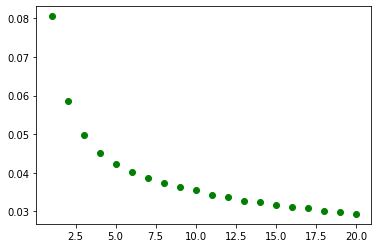

In [32]:
# Initialize model using GPU

dropout_rate = 0.2

mlp_on_gpu = MLP(size_input, size_hidden, size_output, device = 'gpu')
time_start = time.time()
for epoch in range(NUM_EPOCHS):

  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0

  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(9630)).batch(40)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0

  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_gpu.forward(inputs)
    loss_total = loss_total + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)

  preds = mlp_on_gpu.forward(X_train)
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, 'float'))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {}'.format(ds))
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))

  preds_val = mlp_on_gpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')
 
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
# For per epoch_time
# epoch_time = Total time / Number of epochs

#Test Model

In [33]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

# test_loss_total = 0.0
dropout_rate = 0.0

for inputs, outputs in test_ds:
  preds = mlp_on_gpu.forward(inputs)
  # b = mlp_on_gpu.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_gpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))


# Test model
preds_test = mlp_on_gpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))


# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)

Test loss: 0.0258

Test Accuracy: 0.81
